In this expriment,  we will use the Unet architecture on an oxford dataset for image segmentation. 

In [4]:
import tensorflow as tf #ml framework
from tensorflow import keras #high-level API, allows for readable and easy model building fromt tensor. 
from tensorflow.keras import layers #layers module for building neural network layers
import tensorflow_datasets as tfds  #TensorFlow Datasets (TFDS) is a library that provides ready-to-use machine learning datasets for TensorFlow.
import matplotlib.pyplot as plt #plotting library for visualizing data and model performance
import numpy as np 

In [6]:
dataset, info = tfds.load('oxford_iiit_pet:4.*.*', with_info=True)
#importing the Oxford-IIIT Pet Dataset using TensorFlow Datasets (TFDS). The dataset contains images of pets along with their segmentation masks. 
# The 'with_info=True' argument indicates that additional metadata about the dataset should also be returned.

Dl Completed...: 0 url [00:00, ? url/s]
Dl Completed...: 100%|██████████| 2/2 [05:38<00:00, 161.91s/ url]

Dl Completed...: 100%|██████████| 2/2 [05:39<00:00, 161.91s/ url]

Dl Completed...: 100%|██████████| 2/2 [05:40<00:00, 161.91s/ url]

Dl Completed...: 100%|██████████| 2/2 [05:41<00:00, 161.91s/ url]

Dl Completed...: 100%|██████████| 2/2 [05:42<00:00, 161.91s/ url]

Dl Completed...: 100%|██████████| 2/2 [05:43<00:00, 161.91s/ url]

Dl Completed...: 100%|██████████| 2/2 [05:44<00:00, 161.91s/ url]

Dl Completed...: 100%|██████████| 2/2 [05:45<00:00, 161.91s/ url]

Dl Completed...: 100%|██████████| 2/2 [05:46<00:00, 161.91s/ url]

Dl Completed...: 100%|██████████| 2/2 [05:47<00:00, 161.91s/ url]

Dl Completed...: 100%|██████████| 2/2 [05:48<00:00, 161.91s/ url]

Dl Completed...: 100%|██████████| 2/2 [05:49<00:00, 161.91s/ url]

Dl Completed...: 100%|██████████| 2/2 [05:50<00:00, 161.91s/ url]

Dl Completed...: 100%|██████████| 2/2 [05:51<00:00, 161.91s/ url]

Dl Completed...: 100%|

Dataset oxford_iiit_pet downloaded and prepared to /Users/satyam/tensorflow_datasets/oxford_iiit_pet/4.0.0. Subsequent calls will reuse this data.


In [ ]:
print (info)


tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/4.0.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed and
    species. Additionally, head bounding boxes are provided for the training split,
    allowing using this dataset for simple object detection tasks. In the test
    split, the bounding boxes are empty.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_dir='/Users/satyam/tensorflow_datasets/oxford_iiit_pet/4.0.0',
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=773.68 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'head_bbox': BBoxFeature(shape=(4,), dtype=float32),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': 

In [14]:
print(info.features.keys())
print(info.features)



dict_keys(['image', 'label', 'species', 'file_name', 'segmentation_mask', 'head_bbox'])
FeaturesDict({
    'file_name': Text(shape=(), dtype=string),
    'head_bbox': BBoxFeature(shape=(4,), dtype=float32),
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=37),
    'segmentation_mask': Image(shape=(None, None, 1), dtype=uint8),
    'species': ClassLabel(shape=(), dtype=int64, num_classes=2),
})


#### Data preprocessing:  In previous classification tasks, preprocessing functions were built into
#### high-level loaders (e.g., automatic resizing and normalization when reading
#### a single image).

#### Segmentation is different because each sample contains BOTH an image and
#### a mask. These must be transformed together so pixel labels remain aligned.

#### Built-in loaders do not handle paired transformations, so we define our
#### own preprocessing functions (resize, augment, normalize) to process the
#### image and mask simultaneously.


In [8]:
# Resize images and segmentation masks to a fixed size so they can be batched
# and processed by the neural network efficiently. A consistent input shape
# is required for training. Nearest-neighbor interpolation preserves discrete
# class labels in the mask.
#
# Example of nearest-neighbor resizing:
# Original 2×2 mask:
# 1 2
# 3 4
#
# Resized to 4×4:
# 1 1 2 2
# 1 1 2 2
# 3 3 4 4
# 3 3 4 4
#
# Pixel values are copied directly instead of averaged, so class labels remain valid.

# In classification (like the VGG16 pipeline), image_dataset_from_directory
# automatically resizes images when loading them because it only handles
# image → label classification.
#
# Segmentation datasets are different: each sample has an image AND a mask.
# Both must be resized together so pixel labels stay aligned.
#
# TFDS provides raw image + mask pairs and does not resize automatically,
# so we manually resize inside a preprocessing function to keep them synchronized.
#
# Classification → loader handles resizing
# Segmentation → we must resize image and mask ourselves
# Hence the difference in both approaches.

def resize(input_image, input_mask):
    input_image = tf.image.resize(input_image, (128, 128), method="nearest")
    input_mask = tf.image.resize(input_mask, (128, 128), method="nearest")

    return input_image, input_mask 

In [9]:
# Data augmentation = a technique that artificially increases dataset diversity
# by applying random transformations (flip, rotate, crop, etc.) to training images.
#
# Augmentation is applied on-the-fly during training, not stored permanently.
# Each time the model requests a sample, the augment() function runs and may
# randomly modify the image. The transformed image is used for that batch
# and then discarded.
#
# The dataset file count does NOT increase, but the model sees different
# variations of the same images across epochs. Example:
# epoch 1 → flipped
# epoch 2 → original
# epoch 3 → flipped again
#
# This increases effective dataset diversity without increasing storage,
# helping the model generalize better and reduce overfitting.
#
# Pipeline idea:
# stored image → augmentation → model → discard → repeat next epoch


def augment(input_image, input_mask):
    if tf.random.uniform(()) > 0.5:
        # Random flipping of the image and mask
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    return input_image, input_mask

In [10]:
# Normalize image pixel values and adjust mask labels.
#
# Images are converted to float32 and scaled from [0,255] → [0,1].
# Neural networks train more stably when inputs are in a small,
# consistent numeric range instead of large integer values.
#
# The segmentation mask labels are shifted down by 1 so classes start
# from 0 instead of 1 (many loss functions expect class indices to
# begin at 0). Example:
# original labels: 1,2,3 → normalized labels: 0,1,2
#
# Image normalization affects learning stability.
# Mask shifting preserves correct class indexing.

def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1

    return input_image, input_mask

# **Loading the Training and Test Dataset**

In [ ]:
def load_image_train(datapoint):
    input_image = datapoint["image"] # the names of the class we got from above by doing info.features.key
    input_mask = datapoint["segmentation_mask"]
    input_image, input_mask = resize(input_image, input_mask)
# No augmentation for test data What goes wrong if you augment test data

#Imagine flipping images randomly:

#run 1 → model accuracy = 82%

#run 2 → accuracy = 79%

#run 3 → accuracy = 85%
# therfore we make another function for test data without augmentation. 
    input_image, input_mask = augment(input_image, input_mask)
    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [18]:
def load_image_test(datapoint):
    input_image = datapoint["image"]
    input_mask = datapoint["segmentation_mask"]
    input_image, input_mask = resize(input_image, input_mask)
    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [19]:
train_dataset = dataset["train"].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = dataset["test"].map(load_image_test, num_parallel_calls=tf.data.AUTOTUNE)
# Apply preprocessing functions to every dataset sample using .map().
# load_image_train is applied to training data (includes augmentation).
# load_image_test is applied to test data (no augmentation).
#
# num_parallel_calls=tf.data.AUTOTUNE lets TensorFlow automatically
# parallelize preprocessing for better performance.


In [20]:
# Build optimized training pipeline:
# cache() → store dataset in memory after first pass for faster epochs
# shuffle() → randomize sample order to improve generalization
# batch() → group samples into batches
# repeat() → loop dataset indefinitely during training
# prefetch() → prepare next batch while GPU is training

# Validation/test datasets are split by slicing the test dataset.
BATCH_SIZE = 64
BUFFER_SIZE = 1000
train_batches = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_batches = train_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_batches = test_dataset.take(3000).batch(BATCH_SIZE)
test_batches = test_dataset.skip(3000).take(669).batch(BATCH_SIZE)

In [ ]:
# Visualization function to display input image, true mask, and predicted mask side by side.
# These need to be passed as a list to the display function.
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ["Input Image", "True Mask", "Predicted Mask"]

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis("off")
  plt.show()

2026-02-04 21:36:36.669852: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:396] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608


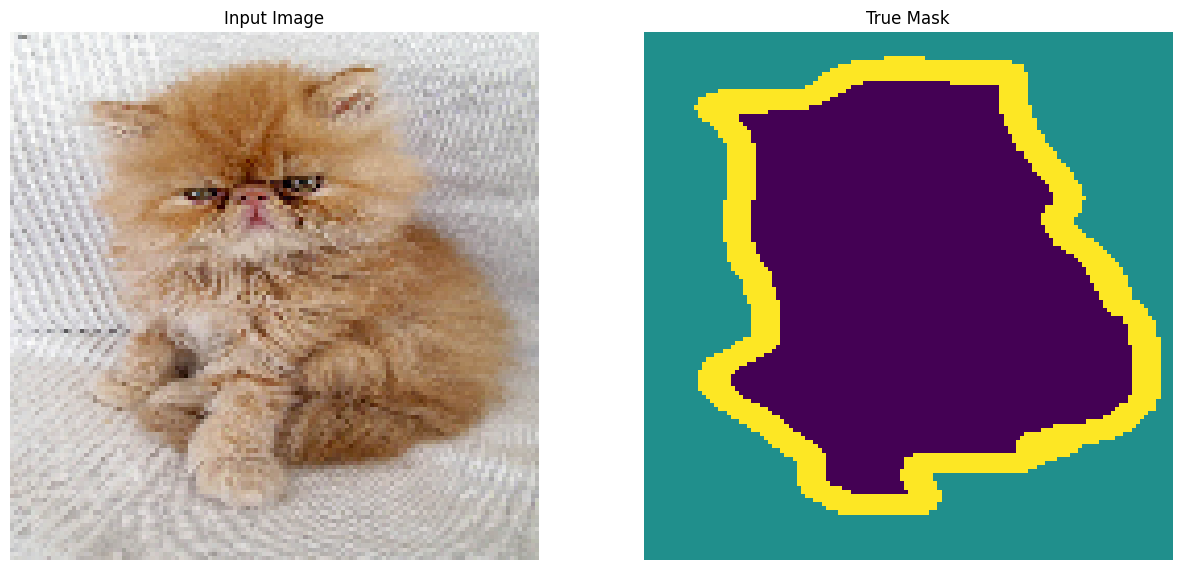

In [22]:
sample_batch = next(iter(test_batches))
random_index = np.random.choice(sample_batch[0].shape[0])
sample_image, sample_mask = sample_batch[0][random_index], sample_batch[1][random_index]
display([sample_image, sample_mask])

#### U-Net is a convolutional neural network designed for semantic segmentation,
#### where every pixel in an image is assigned a class label. It has a symmetric
#### encoder–decoder architecture shaped like a “U”.
####
#### Encoder (contracting path):
#### Repeated blocks of convolution + ReLU + convolution + ReLU + max pooling.
#### This stage progressively downsamples the image while extracting features.
#### Spatial resolution decreases, but semantic understanding increases.
#### The encoder answers: “what object is present?”
#
#### Bottleneck:
#### The deepest layer with the smallest spatial size and richest features.
#### It contains high-level semantic information about the image.
#
#### Decoder (expanding path):
#### Each block upsamples the feature map (via transposed convolution or upsampling),
#### concatenates it with the corresponding encoder feature map (skip connection),
#### then applies convolution layers to refine the prediction.
#### The decoder restores spatial resolution and answers:
#### “where exactly is the object?”
#
#### Skip connections:
#### Pooling removes fine spatial detail. Skip connections pass high-resolution
#### encoder feature maps directly to the decoder so boundary and edge information
#### is preserved. This allows precise segmentation instead of blurry outputs.
#
#### Final layer:
#### A 1×1 convolution produces class probabilities for every pixel.
#### Argmax is applied only at the end to select the final class label per pixel.
#
#### In summary:
#### Encoder → extracts meaning
#### Decoder → reconstructs pixel locations
#### Skip connections → restore lost spatial detail
#### Output → pixel-wise segmentation mask


In [24]:
# Double convolution block used in U-Net for encoder-style feature extraction.
# It applies two 3×3 convolutions with ReLU activation to enrich features
# while preserving spatial resolution (padding="same").
#
# This block extracts patterns and textures but does NOT downsample the image;
# spatial reduction happens later through pooling layers.
#
# U-Net uses two convolutions per block as a balance between feature richness
# and computational cost. Adding more convolutions would increase parameters,
# memory usage, and overfitting risk without proportional benefit. Two layers
# provide strong feature extraction while keeping the model efficient.
# he_normal initializes weifghts to values that help maintain stable gradients during training,
# especially with ReLU activations. This initialization method draws weights from
# a truncated normal distribution scaled according to the number of input units.

def double_conv_block(x, n_filters):

    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)

    return x

# We use this function with maxpooling to build the encoder path of U-Net.
# Each step applies double_conv_block followed by 2×2 max pooling to
# downsample the feature maps, reducing spatial dimensions while increasing
# feature depth. This captures hierarchical features at multiple scales.

In [25]:
# Downsampling encoder block:
# 1) double_conv_block extracts features (f)
# 2) max pooling reduces spatial size (p)
# 3) dropout regularizes to prevent overfitting Randomly drops 30% of activations during training.Prevents overfitting.
# Forces network to learn robust features.
# f is saved for skip connections.
# p is passed to the next encoder stage.
def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(0.3)(p)

    return f, p

In [26]:
def upsample_block(x, conv_features, n_filters):
    # upsample
    x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
    # concatenate
    x = layers.concatenate([x, conv_features])
    # dropout
    x = layers.Dropout(0.3)(x)
    # Conv2D twice with ReLU activation
    x = double_conv_block(x, n_filters)

    return x
# Dry run of one U-Net upsample block (decoder stage)

# Assume inputs:
# x              = decoder feature map from deeper layer
# conv_features  = skip features from encoder
#
# Example shapes:
# x = (batch, 32, 32, 256)
# conv_features = (batch, 64, 64, 128)

# Step 1 — Upsampling (Conv2DTranspose)
# Doubles spatial resolution
# 32×32 → 64×64
# channels set to n_filters = 128
#
# x becomes:
# (batch, 64, 64, 128)

# Step 2 — Concatenate skip connection
# Merge encoder spatial detail with decoder context
# Concatenation stacks channels, not width/height
# 128 + 128 = 256 channels
#
# x becomes:
# (batch, 64, 64, 256)

# Step 3 — Dropout
# Randomly zero 30% activations (training only)
# No shape change
#
# x remains:
# (batch, 64, 64, 256)

# Step 4 — Double convolution block
# Two Conv layers refine features
# Channels compressed back to n_filters
# 256 → 128
#
# Final output:
# (batch, 64, 64, 128)

# Summary flow:
# 32×32×256
# → upsample → 64×64×128
# → concat   → 64×64×256
# → refine   → 64×64×128

# This output is passed to the next decoder stage.


In [28]:
# Builds full U-Net architecture.
# Encoder progressively downsamples while extracting features.
# Bottleneck holds deepest semantic representation.
# Decoder upsamples and merges encoder skip connections
# to restore spatial detail.
# Final 1×1 convolution outputs class probabilities per pixel.

def build_unet_model():

    # inputs
    inputs = layers.Input(shape=(128,128,3))

    # encoder: contracting path - downsample
    # 1 - downsample
    f1, p1 = downsample_block(inputs, 64)
    # 2 - downsample
    f2, p2 = downsample_block(p1, 128)
    # 3 - downsample
    f3, p3 = downsample_block(p2, 256)
    # 4 - downsample
    f4, p4 = downsample_block(p3, 512)

    # 5 - bottleneck
    bottleneck = double_conv_block(p4, 1024)

    # decoder: expanding path - upsample
    # 6 - upsample
    u6 = upsample_block(bottleneck, f4, 512)
    # 7 - upsample
    u7 = upsample_block(u6, f3, 256)
    # 8 - upsample
    u8 = upsample_block(u7, f2, 128)
    # 9 - upsample
    u9 = upsample_block(u8, f1, 64)

    # outputs
    outputs = layers.Conv2D(3, 1, padding="same", activation = "softmax")(u9)

    # unet model with Keras Functional API
    # WE PASS inputs and outputs to define the model.
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

    return unet_model

In [29]:
unet_model = build_unet_model()

In [30]:
unet_model.summary()

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64, 64,    │          0 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ dropout[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32, 32,    │          0 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ dropout_1[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 16, 16,    │          0 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │  1,180,160 │ dropout_2[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 512) │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 8, 8, 512) │          0 │ max_pooling2d_3[

 Total params: 34,513,475 (131.66 MB)

 Trainable params: 34,513,475 (131.66 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
NUM_EPOCHS = 20
# Number of full training cycles over the dataset.
# The model will see training data 20 times.

TRAIN_LENGTH = info.splits["train"].num_examples
# Total number of training samples in the dataset.
# Retrieved from TFDS metadata.

STEPS_PER_EPOCH = BATCH_SIZE
# Number of batches considered as one epoch.
# Since the dataset is infinite (.repeat()), we manually define
# how many batches count as a full epoch.

VAL_SUBSPLITS = 5
# We divide the test dataset into 5 parts and only use
# a fraction for validation each epoch.

TEST_LENGTH = info.splits["test"].num_examples
# Total number of test samples in the dataset.

VALIDATION_STEPS = TEST_LENGTH // BATCH_SIZE // VAL_SUBSPLITS
# Number of validation batches per epoch.
# We only evaluate on 1/5 of the test set to reduce computation.

model_history = unet_model.fit(
    train_batches,
    # Training dataset pipeline (infinite stream of augmented batches)

    epochs=NUM_EPOCHS,
    # Train for 20 epochs

    steps_per_epoch=STEPS_PER_EPOCH,
    # How many training batches make one epoch

    validation_steps=VALIDATION_STEPS,
    # How many validation batches to run after each epoch

    validation_data=validation_batches
    # Dataset used only for evaluation (no weight updates)
)


Epoch 1/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 781s 12s/step - accuracy: 0.5813 - loss: 0.9113 - val_accuracy: 0.5733 - val_loss: 0.8761
Epoch 2/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 734s 11s/step - accuracy: 0.6276 - loss: 0.7950 - val_accuracy: 0.7041 - val_loss: 0.7182
Epoch 3/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 752s 12s/step - accuracy: 0.7256 - loss: 0.6665 - val_accuracy: 0.7502 - val_loss: 0.6065
Epoch 4/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 737s 12s/step - accuracy: 0.7676 - loss: 0.5839 - val_accuracy: 0.7927 - val_loss: 0.5235
Epoch 5/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 740s 12s/step - accuracy: 0.7953 - loss: 0.5223 - val_accuracy: 0.7957 - val_loss: 0.5135
Epoch 6/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 754s 12s/step - accuracy: 0.8165 - loss: 0.4748 - val_accuracy: 0.8299 - val_loss: 0.4420
Epoch 7/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 729s 11s/step - accuracy: 0.8309 - loss: 0.4374 - val_accuracy: 0.8403 - val_loss: 0.4097
Epoch 8/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 776s 12s/step - accuracy: 0.8408 - loss: 0.4150 - val_accuracy: 0.

In [ ]:
class MeanIoUWrapper(tf.keras.metrics.MeanIoU):
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.argmax(y_pred, axis=-1)
        return super().update_state(y_true, y_pred, sample_weight)

unet_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss="sparse_categorical_crossentropy",
    metrics=[MeanIoUWrapper(num_classes=37)]
)

unet_model.evaluate(test_batches)

# evaluation of image segmentation model is different from classification because we need to compare predicted masks with true masks pixel by pixel.
# hence here we use ioU (intersection over union) metric which is more suitable for segmentation tasks.
# IoU measures the overlap between predicted and true masks, giving a better sense of segmentation accuracy
# here we get IoU score of around 0.6 which is decent for segmentation tasks.

11/11 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step - loss: 0.3405 - mean_io_u_wrapper_2: 0.6923


[0.3405485153198242, 0.6922681927680969]

In [34]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [35]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = unet_model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [36]:
count = 0
for i in test_batches:
    count +=1
print("number of batches:", count)

number of batches: 11


2026-02-06 10:02:38.791452: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step


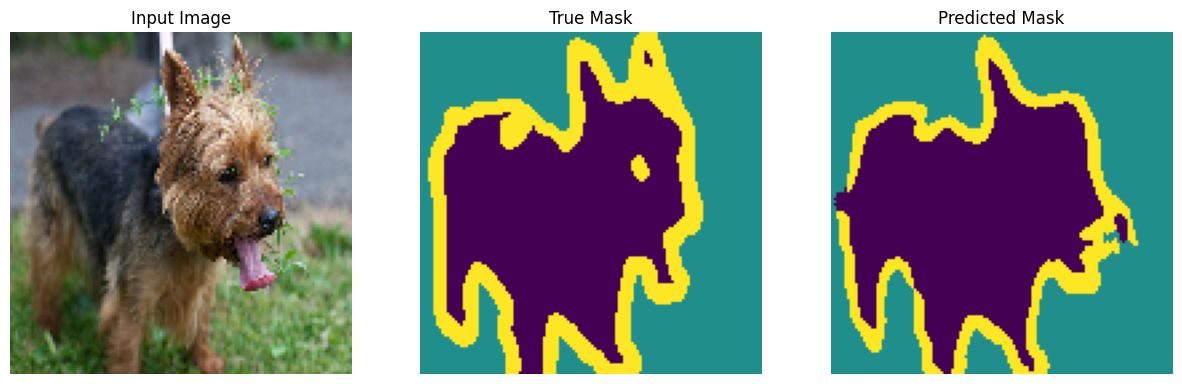

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step


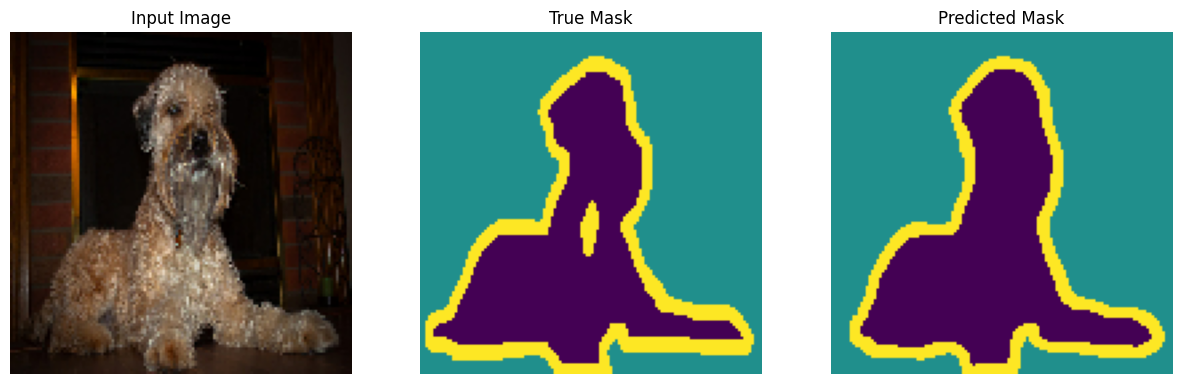

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step


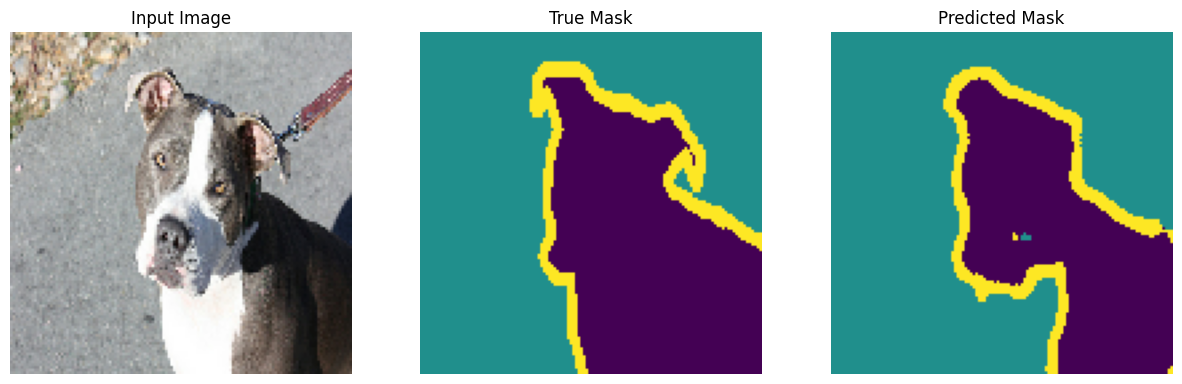

2026-02-06 10:02:59.775470: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [37]:
show_predictions(test_batches.skip(5), 3)